# Notebook universel pour l'entraînement et l'utilisation de modèles IA

Modifiez simplement l'import du modèle pour entraîner ou utiliser un autre type de modèle (CNN, LSTM, GRU, TCN, etc.).

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

from Models.cnn_model import CNNModel as SelectedModel
# from Models.lstm_model import LSTMModel as SelectedModel
# from Models.gru_model import GRUModel as SelectedModel
# from Models.tcn_model import TCNModel as SelectedModel
# from Models.tft_model import TFTModel as SelectedModel # Probleme d'import avec TFT
# from Models.inception_time_model import InceptionTimeModel as SelectedModel # Probleme d'import avec TSAI
# from Models.iterative_knn_model import IterativeKNNModel as SelectedModel


def load_dataset(base_path):
    all_data = []
    labels = []
    for label_name in ["Normal", "Accident"]:
        folder_path = os.path.join(base_path, label_name)
        if not os.path.exists(folder_path):
            continue
        for file_name in os.listdir(folder_path):
            if file_name.endswith(".csv"):
                file_path = os.path.join(folder_path, file_name)
                df = pd.read_csv(file_path)
                if not all(col in df.columns for col in ["ACCX", "ACCY", "ACCZ"]):
                    continue
                if any(len(df[col]) < 2 for col in ["ACCX", "ACCY", "ACCZ"]):
                    continue
                features = []
                for col in ["ACCX", "ACCY", "ACCZ"]:
                    signal = df[col].values
                    features.extend(
                        [
                            signal,
                            np.gradient(signal),
                            np.gradient(np.gradient(signal)),
                        ]
                    )
                features = np.array(features).flatten()
                all_data.append(features)
                labels.append(label_name)
    return all_data, labels


def pad_sequences(data, max_len=None):
    if max_len is None:
        max_len = max(len(seq) for seq in data)
    padded_data = [np.pad(seq, (0, max_len - len(seq)), "constant") for seq in data]
    return np.array(padded_data)

## Entraînement du modèle sélectionné

Epoch 1/5


/Users/rdb_samy/miniconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


400/400 ━━━━━━━━━━━━━━━━━━━━ 38s 91ms/step - accuracy: 0.7597 - loss: 0.7303 - val_accuracy: 0.5411 - val_loss: 1.3172 - learning_rate: 0.0010
Epoch 2/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 40s 99ms/step - accuracy: 0.8174 - loss: 0.4692 - val_accuracy: 0.9501 - val_loss: 0.2736 - learning_rate: 0.0010
Epoch 3/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 37s 92ms/step - accuracy: 0.8394 - loss: 0.4027 - val_accuracy: 0.6933 - val_loss: 0.5328 - learning_rate: 0.0010
Epoch 4/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 35s 87ms/step - accuracy: 0.8648 - loss: 0.3935 - val_accuracy: 0.6733 - val_loss: 0.5267 - learning_rate: 0.0010
Epoch 5/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 35s 87ms/step - accuracy: 0.8975 - loss: 0.3294 - val_accuracy: 0.5761 - val_loss: 0.6726 - learning_rate: 0.0010
Test Accuracy: 0.93
              precision    recall  f1-score   support

    Accident       0.96      0.91      0.93       250
      Normal       0.91      0.96      0.94       251

    accuracy                           0.93       501
   macr

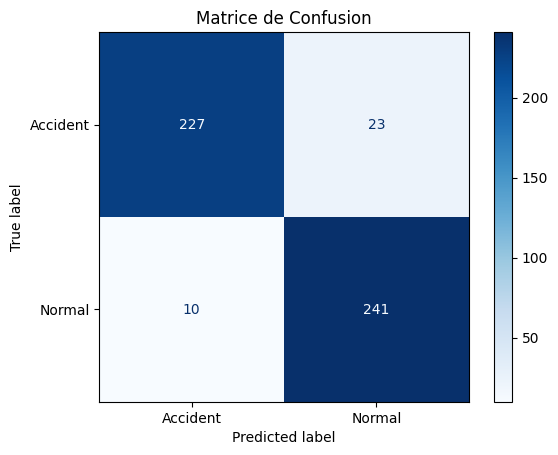

Modèle sauvegardé sous 'Models/model_cnnmodel.h5'.


In [2]:
from collections import defaultdict

base_path = "."
X_raw, y_raw = load_dataset(base_path)

indices_by_class = defaultdict(list)
for idx, label in enumerate(y_raw):
    indices_by_class[label].append(idx)
min_count = min(len(idxs) for idxs in indices_by_class.values())
balanced_indices = []
for label, indices in indices_by_class.items():
    balanced_indices.extend(indices[:min_count])

X_raw = [X_raw[i] for i in balanced_indices]
y_raw = [y_raw[i] for i in balanced_indices]

X = pad_sequences(X_raw)
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = np.expand_dims(X, axis=-1)
le = LabelEncoder()
y = le.fit_transform(y_raw)
y = to_categorical(y)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model = SelectedModel(input_shape=(X.shape[1], 1), num_classes=2)
model.build()
history = model.train(X_train, y_train, X_val=None, y_val=None)

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
print(classification_report(y_test_classes, y_pred_classes, target_names=le.classes_))

cm = confusion_matrix(y_test_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de Confusion")
plt.show()

model.save(f"Models/model_{SelectedModel.__name__.lower()}.h5")
print(f"Modèle sauvegardé sous 'Models/model_{SelectedModel.__name__.lower()}.h5'.")

## Utilisation du modèle sélectionné pour la classification de fichiers individuels

In [3]:
model = SelectedModel(input_shape=None, num_classes=2)
model.load(f"Models/model_{SelectedModel.__name__.lower()}.h5")


In [4]:
from ipywidgets import Dropdown, VBox, Output

output = Output()
raw_data_path = "./Raw_Data"
all_files = [
    os.path.join(raw_data_path, f)
    for f in os.listdir(raw_data_path)
    if f.endswith(".csv")
]

file_selector_dropdown = Dropdown(
    options=[os.path.basename(f) for f in all_files],
    value=os.path.basename(all_files[0]) if all_files else None,
    description="Fichier:",
)

In [11]:
def afficher_classification_par_fichier(change):
    with output:
        output.clear_output()
        selected_file = file_selector_dropdown.value
        if not selected_file:
            print("Aucun fichier sélectionné.")
            return

        fichier_selectionne = os.path.join(raw_data_path, selected_file)
        try:
            data = pd.read_csv(fichier_selectionne)
        except Exception as e:
            print(f"Erreur lors du chargement du fichier {selected_file}: {e}")
            return

        features = ["ACCX", "ACCY", "ACCZ"]
        if not all(feature in data.columns for feature in features):
            print(f"Colonnes {features} manquantes dans le fichier {selected_file}.")
            return
        if data.empty:
            print(f"Le fichier {selected_file} est vide.")
            return

        plt.figure(figsize=(12, 6))
        for feature in features:
            plt.plot(data.index, data[feature], label=feature)
        plt.xlabel("Index")
        plt.ylabel("Valeurs des capteurs")
        plt.title(f"Données et Classification pour {selected_file}")
        plt.grid(True)

        window_size = 100
        overlap = 50
        max_len = model.get_input_length()
        predictions_for_chunks = []

        class_names = ["Accident", "Normal"]
        colors = {"Normal": "blue", "Accident": "red", "Non-classifié": "gray"}

        all_features = []
        for feature in features:
            signal = data[feature].values
            all_features.extend(
                [signal, np.gradient(signal), np.gradient(np.gradient(signal))]
            )
        all_features = np.array(all_features).flatten()
        global_mean = np.mean(all_features)
        global_std = np.std(all_features)

        print(f"Analyse avec fenêtre glissante de {window_size} points:")

        for start in range(0, len(data) - window_size + 1, overlap):
            end = start + window_size
            data_chunk = data.iloc[start:end]

            chunk_features = []
            for feature in features:
                signal = data_chunk[feature].values
                chunk_features.extend(
                    [signal, np.gradient(signal), np.gradient(np.gradient(signal))]
                )
            chunk_features = np.array(chunk_features).flatten()

            chunk_features = (chunk_features - global_mean) / global_std

            if len(chunk_features) >= max_len:
                padded_chunk = chunk_features[:max_len]
            else:
                padded_chunk = np.pad(
                    chunk_features, (0, max_len - len(chunk_features)), "constant"
                )

            model_input = np.expand_dims(padded_chunk, axis=(0, -1))

            try:
                prediction = model.predict(model_input)
                confidence = np.max(prediction)
                predicted_class_index = np.argmax(prediction, axis=1)[0]

                if confidence > 0.80:
                    predicted_class_name = class_names[predicted_class_index]

                    if len(predictions_for_chunks) > 0:
                        last_pred = predictions_for_chunks[-1][2]
                        if (
                            last_pred != "Non-classifié"
                            and last_pred != predicted_class_name
                        ):
                            if confidence < 0.90:
                                predicted_class_name = "Non-classifié"
                else:
                    predicted_class_name = "Non-classifié"

                predictions_for_chunks.append((start, end, predicted_class_name))
            except Exception as e:
                print(f"  Segment {start}-{end}: Erreur de prédiction: {e}")
                predictions_for_chunks.append((start, end, "Non-classifié"))

        current_class = "Non-classifié"
        current_start = 0

        for i, (start, end, predicted_class) in enumerate(predictions_for_chunks):
            if predicted_class != current_class:
                if current_class != "Non-classifié":
                    plt.axvspan(
                        current_start,
                        start,
                        color=colors[current_class],
                        alpha=0.3,
                        label=f"_{current_class}_",
                    )
                current_class = predicted_class
                current_start = start

        if current_class != "Non-classifié":
            plt.axvspan(
                current_start,
                len(data),
                color=colors[current_class],
                alpha=0.3,
                label=f"_{current_class}_",
            )

        handles = [
            plt.Rectangle((0, 0), 1, 1, fc=color, alpha=0.3)
            for color in [colors["Normal"], colors["Accident"]]
        ]
        labels = ["Normal", "Accident"]

        handles.extend(
            [
                plt.Line2D([0], [0], color="blue", label="ACCX"),
                plt.Line2D([0], [0], color="orange", label="ACCY"),
                plt.Line2D([0], [0], color="green", label="ACCZ"),
            ]
        )
        labels.extend(["ACCX", "ACCY", "ACCZ"])

        plt.legend(handles=handles, labels=labels)
        plt.show()

In [12]:
file_selector_dropdown.observe(afficher_classification_par_fichier, names="value")
display(VBox([file_selector_dropdown, output]))